In [1]:
name="JETSCAPE_bayes"

In [2]:
#import GPy
import os
import pickle
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
sns.set()
from sklearn.decomposition import PCA
#import sys
from numpy.linalg import inv
#sys.path.insert(0, '/Users/dananjayaliyanage/git/emulator-validation/src')
#from configurations import load_design, transform_design
#from bayes_mcmc import *
#from calculations_load import trimmed_model_data,validation_data
#from bins_and_cuts import *
#import matplotlib.patches as mpatches
from bayes_exp import Y_exp_data
from sklearn.preprocessing import StandardScaler
#EMU='LHCemulators.dat'
#Tobs='LHCTobs.dat'
#obsName='obsnames.dat'
#Tdesign='LHCdes.dat'
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]', '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]', '$(\\eta/s)_{\\mathrm{kink}}$', '$(\\zeta/s)_{\\max}$', '$T_{\\zeta,c}$ [GeV]', '$w_{\\zeta}$ [GeV]', '$\\lambda_{\\zeta}$', '$b_{\\pi}$', '$T_{\\mathrm{sw}}$ [GeV]'], 'ma

In [3]:
import emcee
import ptemcee
import h5py
import numpy as np
from scipy.linalg import lapack
from multiprocessing import Pool
from multiprocessing import cpu_count

In [4]:
EMU='LHCemulators.dat'
Tobs='LHCTobs.dat'
obsName='obsnames.dat'
Tdesign='LHCdes.dat'

In [5]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

In [6]:
if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

In [7]:
from calculations_load import *
from configurations import *

In [8]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

#perform a transformation of the design, swapping the original parameters
#for inputs more naturally/simply related to the outputs
do_transform_design = True
if do_transform_design:
    X = transform_design(X.values)

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)

Y = np.array([])
for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
        
Y = Y.reshape(X.shape[0], -1)

In [9]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 29)
Y.shape : (485, 110)


In [10]:
SS  =  StandardScaler(copy=True)

In [11]:
pca_analysis = PCA(n_components=10, whiten=True, svd_solver='full')

In [12]:
pca_analysis.fit(SS.fit_transform(Y))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='full', tol=0.0, whiten=True)

In [13]:
Transformed_data=pca_analysis.transform(SS.fit_transform(Y))
Transformed_data[:,1].shape

(485,)

In [14]:
# Let's construct the transformation matrix for inverse PC
trans_matrix = (
            pca_analysis.components_
            * np.sqrt(pca_analysis.explained_variance_).reshape(10,1)
            * SS.scale_.reshape(1,110)
        )
A=trans_matrix

In [15]:
design_ut,dsgn_min_ut,dsgn_max_ut,design_ut_lbls=load_design(system_str='Pb-Pb-2760')

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 


In [16]:
design, design_max, design_min, labels = prepare_emu_design('Pb-Pb-2760')
if len(delete_design_pts_set) > 0:
    print("Warning! Deleting "
          + str(len(delete_design_pts_set)) + " points from data")
    design = np.delete(design, list(delete_design_pts_set), 0)
alldesign=[design, design_max, design_min,labels]    
with open(Tdesign,"wb") as f:
    pickle.dump(alldesign,f)

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 
Note : Transforming design of viscosities
Warning! Deleting 15 points from data


In [17]:
import time
overide=False
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)
if (os.path.exists(EMU)) and (overide==False):
    print('Emulator.dat exists and overide is prohibited')
    with open(EMU,"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators=[]
    for i in range(0,10):
        start_time = time.time()
        kernel=1*krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (4e-1, 1e2)))+ krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-2, 1e2))#+krnl.ConstantKernel()
        GPR=gpr(kernel=kernel,n_restarts_optimizer=4,alpha=0.0000000001)
        GPR.fit(design,Transformed_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design,Transformed_data[:,i])} \n')
        #print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
        print("--- %s seconds ---" % (time.time() - start_time))
        Emulators.append(GPR)

Emulator.dat exists and overide is prohibited


In [18]:
overide = True
if (overide==True) or not(os.path.exists(EMU)):
    with open(EMU,"wb") as f:
        pickle.dump(Emulators,f)

In [19]:
##Loading the Transformed design space values 
#design,des_max,des_min,lbl=Alldesign

In [20]:
# emulator prediction
def predictObs(Theta):
    """Theta has to have dimension of (n_samples,n_features). Returns the mean value and the full covaraiance matrix
    and then the diagonals of covaraiance matrix calculated in a simpler way"""
    mean=[]
    Variance=[]
    if Theta.shape!=(1,29):
        raise TypeError('Theta does not have the right dimensions')
    else:    
        for i in range(0,10):
           # mn,std=Emulators[i].predict(Theta.reshape(1,-1),return_std=True)
            mn,std=Emulators[i].predict(Theta.reshape(1,-1),return_std=True)
            mean.append(mn)
            Variance.append(std**2)
    
    mean=SS.inverse_transform(pca_analysis.inverse_transform(np.array(mean).reshape(1,-1)))
    v=np.diag(np.array(Variance).flatten())
    #print(v.shape)
    #meantest=SSS.inverse_transform(pca_analysis.inverse_transform(np.array(mean).reshape(1,-1)))
    vr=np.einsum('ik,kl,lj-> ij', A.T, v, A, optimize=False)
#    vvr=np.array(Variance).reshape(1,-1)
#    Var=descale(np.dot(dewhiten(vvr),np.square(pca_analysis.components_)))
#    np.array(Var).reshape(1,-1)
    #print(f'shape of variance and mean array {Variance.shape} , {mean.shape}')
    return mean, vr

In [21]:
Yexp=[]
Yexperr=[]

for obs in active_obs_list['Pb-Pb-2760']:
    Yexp.extend(Y_exp_data['Pb-Pb-2760'][obs]['mean'][0])
    Yexperr.extend([val**2 for val in Y_exp_data['Pb-Pb-2760'][obs]['err'][0]]) # Experimental error is given as sd. Make it variance
Yexp=np.array(Yexp)
Yexperr=np.array(Yexperr)
print(f'Shape of the experiment observables {Yexp.shape} and shape of the experimental error variance{Yexperr.shape}')

Shape of the experiment observables (110,) and shape of the experimental error variance(110,)


In [22]:
MAP_params = {'Pb-Pb-2760': [14.128, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136],
              'Au-Au-200' : [5.821, 0.089, 1.054, 1.064, 4.227, 1.507, 0.113, 0.223, -1.585, 0.32, 0.056, 0.11, 0.16, 0.093, -0.084, 4.666, 0.136]
                }
#map values has untaransformed MAP values
map_values=np.array(MAP_params["Pb-Pb-2760"])
#MAP has transformed MAP values
MAP=transform_design(map_values.reshape(1,-1))

In [23]:
mm,vv=predictObs(MAP)

In [24]:
dsgn_min_ut

array([10.   , -0.7  ,  0.3  ,  0.5  ,  0.   ,  0.3  , -0.3  ,  0.13 ,
       -2.   , -1.   ,  0.01 ,  0.01 ,  0.12 ,  0.025, -0.8  ,  2.   ,
        0.13 ])

In [25]:
# log prior
# If theta is inside the bounds we will return log 0 otherwise -inf
def log_prior(Theta):
    """Evaluvate the prior at Theta"""
    X = np.array(Theta).reshape(1,-1)
    lower = np.all(X >= dsgn_min_ut)
    upper = np.all(X <= dsgn_max_ut)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [26]:
# Loglikelihood. Experimental error has to be defined by now.
#pcaExper
#exp_error=pcaExpErr.reshape(1,-1))
def log_likelihood(Theta,obs= Yexp.reshape(1,-1), exp_error=Yexperr.reshape(1,-1)):
    total=0
    mn,var=predictObs(Theta.reshape(1,-1))
   # print(f'shape of var and exp error {var.shape}, {exp_error.shape}')
    #total_var=np.add(var,exp_error)
    #total_var=np.add(var.reshape(1,-1),exp_error.reshape(1,-1))
    #total_var=np.diag(exp_error)
    y = np.linalg.inv(var+vrr)
    intotal=np.dot(mn-obs,y)
    total=np.dot(intotal,(mn-obs).T)
    #print(intotal)
   # tt=len(mn)
  #  for i in range(0,tt):
   #     total+=((obs[0,tt]-mn[0,tt])**2)/((total_var[0,tt]))
    #print(f'just {total}, from variance{np.log(total_var).sum()}')
    #print(var.shp)
   # print(np.linalg.det(var))
    
    return -0.5*(np.asscalar(total))/1e15 #+ np.log(np.linalg.det(var)))) #+np.log(total_var).sum())

In [27]:
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
  #  print(L.diagonal())
    a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
   # L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [28]:
def log_posterior(Theta):
    """This function take 17 dim parameter as input and transform it to 29 dim and then proceed."""
    Theta2=transform_design(Theta.reshape(1,-1))
    mn,var=predictObs(Theta2.reshape(1,-1))
  #  y=mn-Yexp.reshape(1,-1)
    #y=mn-Yexp
   # y=mn-mn_cross
    y=mn-Yexp.reshape(1,-1)
  #  tk=[]
  #  for i in y:
  #      tk.append(i)
  #  tt=np.array(tk)
    yy=y.flatten()
   # print(yy)
    exp_var=np.diag(Yexperr)
  #  exp_var=np.diag(vrr.diagonal())
    total_var=var# +cov_trun
    total_var=np.diag(total_var.diagonal())
    #total_var=exp_var
    #print(log_prior(Theta))
#    print(f'using full covariance matrix likelihood log value {mvn_loglike(yy,total_var)}')
#    print(f'only using the diagonal experimental error likelihood log value {mvn_loglike(yy,exp_var)}')


   # print(mvn_loglike(yy,exp_var))
    return log_prior(Theta) + mvn_loglike(yy,total_var)

In [29]:
MAP.shape

(1, 29)

In [30]:
log_posterior(map_values)

-714.9127512663408

In [31]:
#1.5 million
Burn=True
from multiprocessing import Pool
ndim = 17  # number of parameters in the model
nwalkers = 500  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps =2000  # number of MCMC steps to take

filename = data_path(name+".h5")
backend = emcee.backends.HDFBackend(filename)
#print(backend.get_last_sample())
# we'll start at random locations within the prior volume
#starting_guesses = des_min + (des_max - des_min) * np.random.rand(nwalkers,ndim)
starting_guesses = dsgn_min_ut + (dsgn_max_ut - dsgn_min_ut) * np.random.rand(nwalkers,ndim)
print(starting_guesses)
print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, pool=pool, backend=backend)
    print('burn in sampling started')
#for i,pos in enumerate(sampler.sample(starting_guesses, iterations=nburn)):
#    if (i+1) % 100 == 0:
#        print("{0:.1f}%".format(100 * float(i) / nburn))
# "burn-in" period; save final positions and then reset
    if Burn==True:
        backend.reset(nwalkers, ndim)
        print('burn was true going to burnin')
        pos= sampler.run_mcmc(starting_guesses, nburn,progress=True,store = True)
    #samplesburn = backend.get_chain(flat=True)I'm 
#print(pos)
   # print(backend.get_chain(flat=True).shape)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),nwalkers*nburn))


#    sampler.reset() 


# sampling period
    print('Burn in completed. Now running the samples')
    sampler.run_mcmc(initial_state=None,nsteps=nsteps,progress=True, tune= False)  
# for i,pos2 in enumerate(sampler.sample(pos.coords, iterations=nsteps)):
#    if (i+1) % 100 == 0:
#        print("{0:.1f}%".format(100 * float(i) / nsteps))
        
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))

# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = backend.get_chain(flat=True,discard=nburn)

[[14.17022005  0.30845429  0.30019444 ... -0.75617985  6.02280506
   0.14460567]
 [15.58689828 -0.50345829  0.63677253 ... -0.1262278   7.74733718
   0.14866078]
 [16.91877114 -0.25827812  1.46705158 ... -0.33955946  2.78017143
   0.13067784]
 ...
 [17.78303366 -0.4729829   1.43180051 ... -0.35572069  4.91654792
   0.13162857]
 [18.48933275 -0.08593967  0.62350868 ... -0.52001327  5.05733234
   0.14508068]
 [19.58876326  0.67845484  0.56236274 ...  0.45496833  5.40323297
   0.13388389]]
MCMC sampling using emcee (affine-invariant ensamble sampler) with 500 walkers
burn in sampling started
burn was true going to burnin


  0%|          | 0/2000 [00:00<?, ?it/s]

Mean acceptance fraction: 0.198 (in total 250000 steps)
Burn in completed. Now running the samples


100%|██████████| 2000/2000 [42:36<00:00,  1.28s/it]


Mean acceptance fraction: 0.122 (in total 1000000 steps)


In [34]:
from scipy import optimize

In [35]:
bounds=[(a,b) for (a,b) in zip(dsgn_min_ut,dsgn_max_ut)]

In [ ]:
#rslt = optimize.differential_evolution(lambda x: -log_posterior(x), 
#                                       bounds=bounds,
#                                      disp=True,
#                                      tol=1e-7,
 #                                     )

In [ ]:
#map_values_from_this_analysis=rslt.x

In [36]:
map_values_from_this_analysis_saved = np.array([17.0545467 , -0.69282539,  1.28508437,  0.90737851,  4.79186204,
        1.23752569,  0.14938259,  0.24523216, -1.98780229,  1.95919816,
        0.07177706,  0.1808762 ,  0.25314821,  0.11642762,  0.05872212,
        2.00449847,  0.15283203])

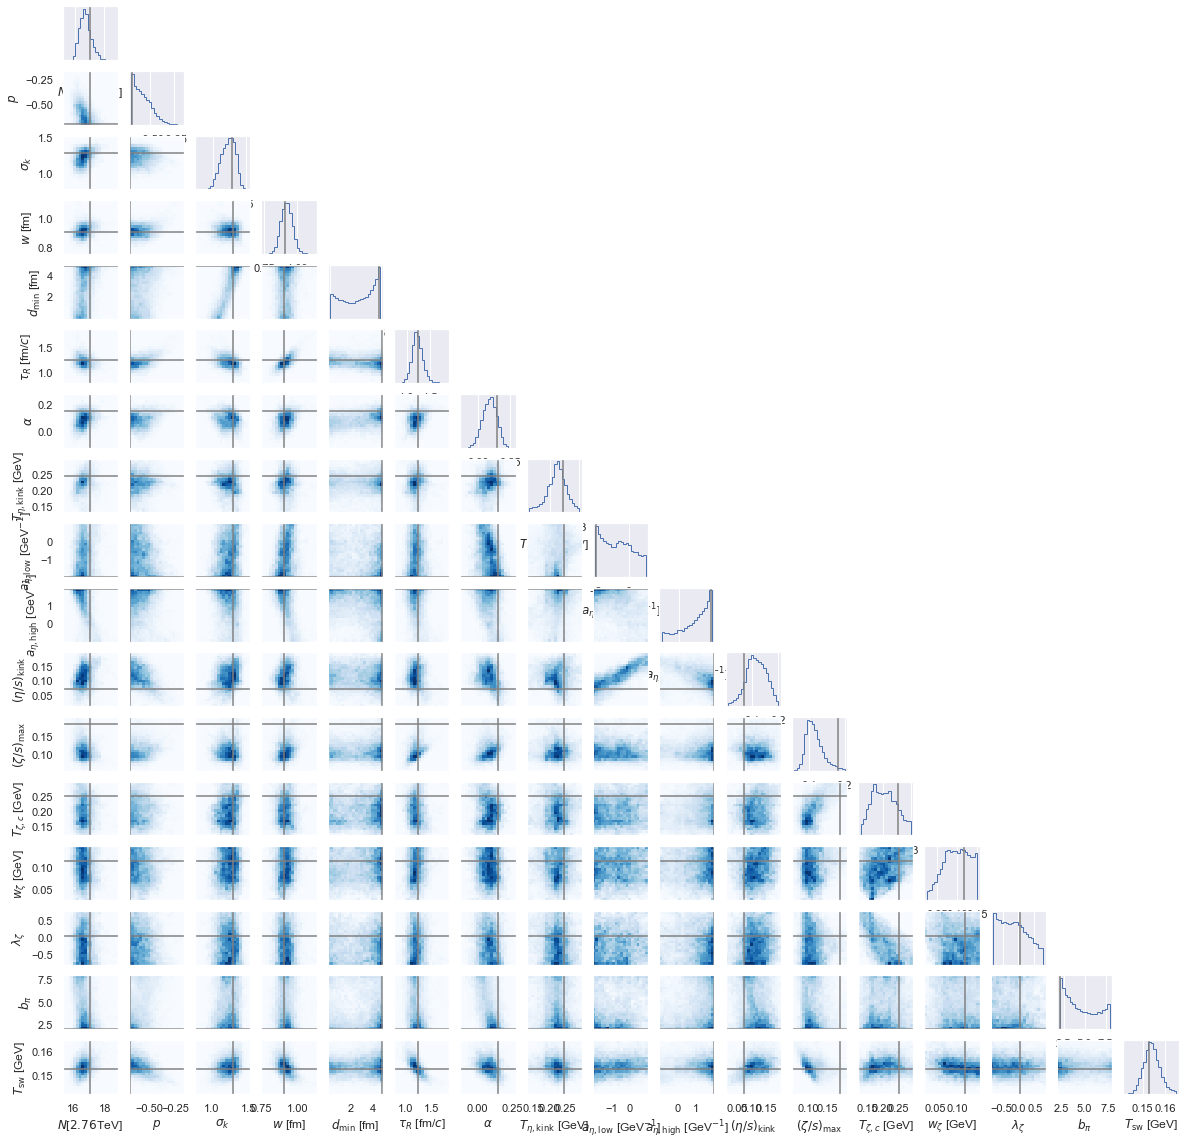

In [46]:
paramsss=map_values_from_this_analysis_saved.reshape(1,-1)
#paramsss=np.array(MAP_params['Pb-Pb-2760']).reshape(1,-1)
#paramsss=crs_vld_params
#clmn=[0,1,2,3,5,6,8]
clmn=[tt for tt in range(0,17)]
columns=[design_ut_lbls[i] for i in clmn]
n=len(columns)
ptype='hist'
#ptype='scatter'
cmap=plt.get_cmap('Blues')
cmap.set_bad('white')
fig,axs2=plt.subplots(nrows=n,ncols=n,figsize=(20,20))
for i in range(0,n):
    for j in range(0,n):
        #ax_n=i+n*j
        ax=axs2[i,j]
        x=samples[:,clmn[j]]
        y=samples[:,clmn[i]]
       #ax.set_xlabel(columns[j])
       #ax.set_ylabel(columns[i])
        if (i>j):
            if ptype=='hist':
                ax.hist2d(x, y, bins=20, cmap=cmap)
                ax.axvline(x=paramsss[0,clmn[j]], c='grey')
                ax.axhline(y=paramsss[0,clmn[i]], c='grey')
                if i==16:
                    ax.set_xlabel(columns[j])
                    if j!=0:
                        ax.set_yticks([])
                if j==0:
                    ax.set_ylabel(columns[i])
                    if i!=16:
                        ax.set_xticks([])
                if (j!=0) and (i!=16):
                    ax.set_xticks([])
                    ax.set_yticks([])
            if ptype=='scatter':
                ax.scatter(x, y, s=.4, color='r')
        if (i==j):
            ax.hist(x, bins=20, histtype='step', density=True)
            #ax.set_ylabel('Prob')
            ax.set_yticks([])
            ax.set_xlabel(columns[i])
            ax.axvline(x=paramsss[0,clmn[j]], c='grey')
        if (i<j):
            ax.axis('off')
save_fig(name+"full")

# Emulator validation
# Closure tests
# Observable predictions from MAP
# Including other systems in the parameter estimation
# Prior/ posterior plots for model parameters.